In [1]:
import os
import sys
import time
from typeguard import typechecked

import jax
import jax.numpy as jnp
import jax.nn as jnn
import jax.random as jrandom

import optax
import diffrax
import equinox as eqx
from equinox.module import static_field

# from jaxtyping import Array, PyTree

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2


In [2]:
jax.config.update("jax_enable_x64", True)

In [3]:
import sys
sys.path.append('/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/lsm-jax/src')
# from lsm_jax import lsm
from lsm_jax.models import LSMVectorMassEnergy, LSMVectorMassOnlyHybrid
from lsm_jax.data import ushn2_forcings


In [4]:
# from lsm_jax.physics import Surface, Soil

In [5]:
from lsm_jax.data.ushn2 import df_obs, df_flux

<AxesSubplot: >

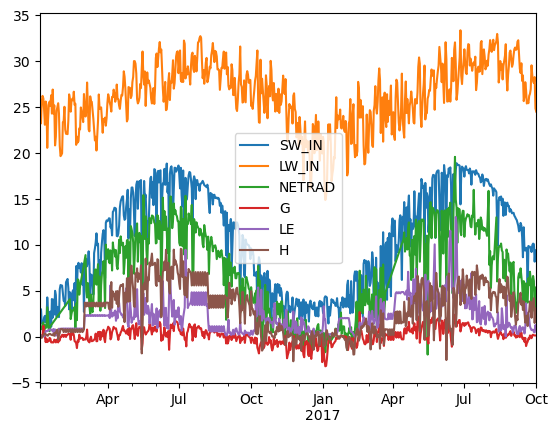

In [6]:
# df_obs['SW_IN'].plot()
# df_obs['LW_IN'].plot()
# df_obs['NETRAD'].plot()
# df_obs['G'].plot()
# df_obs['G'].plot()
# df_obs['G'].plot()
df_obs[['SW_IN', 'LW_IN', 'NETRAD', 'G', 'LE', 'H']].plot()

<AxesSubplot: >

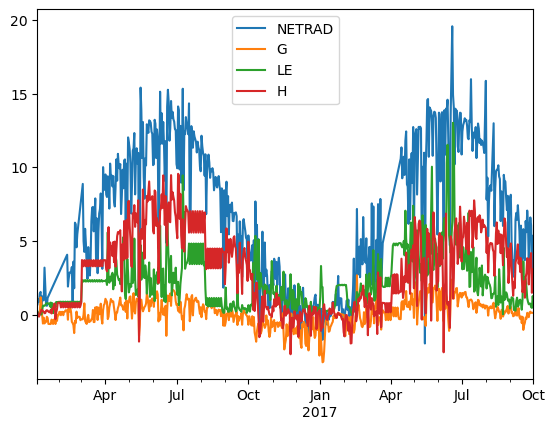

In [7]:
# plt.plot(ushn2_forcings.data[1,:], label='SW_IN')
# plt.plot(ushn2_forcings.data[2,:], label='LW_IN')
# plt.legend()
# # plt.plot(ushn2_forcings.data[2,:] / ushn2_forcings.data[1,:])
# # plt.ylim([-1,1])
df_obs[['NETRAD', 'G', 'LE', 'H']].plot()

# Get the forcing data

In [8]:
# # ushn2_forcings['P'].ys.min()
# ushn2_forcings.varn_list
# ushn2_forcings.n_var

# Create an instance for the LSM vector fields
Some reference on soil thermal properties: 
- https://www.sciencedirect.com/science/article/pii/S1537511003001120
- https://open.library.okstate.edu/rainorshine/chapter/13-2-soil-thermal-properties/

In [9]:
parameters = dict(
    albedo=0.1, emissivity=0.3,
    dfr=2., dsl=0.05,
    alpha_sl=1.32, alpha_fr=1.32,
    n_sl=2., n_fr=2.,
    ksat_sl=3e-7*86400, ksat_fr=3e-7*86400,
    theta_r_sl=0.0001, theta_r_fr=0.0001,
    theta_sat_sl=0.43, theta_sat_fr=0.43,
    theta_wp=0.01, theta_lim=0.2,
    kthermal=2.*86400*1e-6, rhos=1300., cs=2e-3,
    tamin=-1., tamax=40., taopt=22., w=0.01,
    rsmin=100., dh=2.5,
    zh=5., zm=5., zoh=0.5/2.5, zom=0.05,
    xit=0.8, fbs=.2, fv=0.8
)

In [10]:
lsm_vector = LSMVectorMassEnergy(**parameters)

In [11]:
# y0 = jnp.array([0.05, 0.05, 0.1, 0.3, 1.3, 1.3])
# lsm_vector(0, y0, ushn2_forcings)

In [12]:
# df_obs.iloc[150:]['TS'].plot()
print('This is suspicious!')
df_obs.iloc[[150,505]][['H', 'TS', 'TA', 'WS']]

This is suspicious!


,H,TS,TA,WS
2016-06-03,8.433331,32.302,22.519,1.303
2017-05-24,1.691980,27.494,15.587,4.440


<AxesSubplot: >

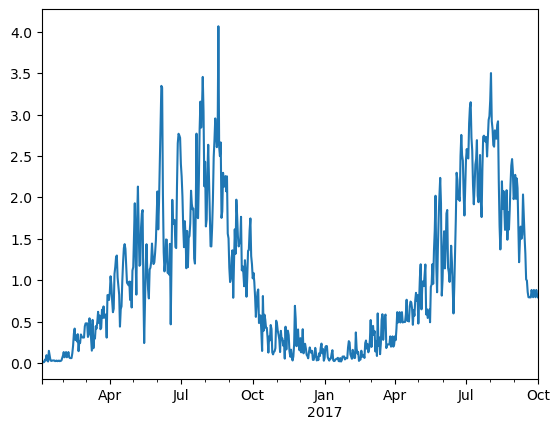

In [13]:
df_obs['VPD'].plot()

In [14]:
y0 = jnp.array([0.05, 0.05, 0.1, 0.3, -1., -1.])
lsm_vector(0, y0, ushn2_forcings)

Array([-9.08816963e-03, -5.81274453e-06,  0.00000000e+00,  1.50000000e-05,
        2.58274008e-01,  0.00000000e+00], dtype=float64)

In [15]:
y0 = jnp.array([0.05, 0.05, 0.1, 0.3, 32, 32])
lsm_vector(150, y0, ushn2_forcings)

Array([-3.81788512e-02, -1.84177669e-04,  0.00000000e+00,  0.00000000e+00,
       -9.74686376e-01,  0.00000000e+00], dtype=float64)

In [16]:
y0 = jnp.array([0.05, 0.05, 0.1, 0.3, 28, 28])
lsm_vector(505, y0, ushn2_forcings)

Array([-6.76679611e-02, -3.68720899e-04,  0.00000000e+00,  0.00000000e+00,
       -1.57214954e+01,  0.00000000e+00], dtype=float64)

In [17]:
# solution_untrained.ts[1][5050]
# solution_untrained.ys[0][5050,:], solution_untrained.ys[1][5050,:]

# Calibrate a physics-based model
The ODE for water budget:

\begin{align}
\frac{d\theta_{sl}}{dt} &= \frac{1}{d_{sl}}[I-f_{bs}E_{bs}-f_{v}\xi_tE_{v,rh}-D_r-HR]  \qquad &(\text{surface layer})\\
\frac{d\theta_{fr}}{dt} &= \frac{1}{d_{fr}}[D_r-f_{v}(1-\xi_t)E_{v,fr}+HR-L_e]  \qquad &(\text{fractured rock sublayer}) \\
\end{align}


## Create an ODE class

In [18]:
t0, t1, dt0 = 0, 600, 0.1
ts=jnp.arange(t0,t1,dt0)
y0 = jnp.array([0.05, 0.05, 0.1, 0.3, -1., -1.])

In [19]:
# Also, we need to save the auxiliary states
from lsm_jax.models import calculate_lsm_vector_mass_energy
rhs = lambda t, y, args: calculate_lsm_vector_mass_energy(
    t, y, lsm_ode.lsm.soil, lsm_ode.lsm.surface, args)[0]
aux = lambda t, y, args: calculate_lsm_vector_mass_energy(
    t, y, lsm_ode.lsm.soil, lsm_ode.lsm.surface, args)[1]

saveat_rhs_states = diffrax.SubSaveAt(ts=ts)
saveat_aux_states = diffrax.SubSaveAt(ts=ts, fn=aux)
saveat_both       = diffrax.SaveAt(subs=[saveat_rhs_states, saveat_aux_states])

In [20]:
class LSMODE(eqx.Module):
    lsm: LSMVectorMassEnergy

    def __init__(self, parameters, **kwargs):
        super().__init__(**kwargs)
        self.lsm = LSMVectorMassEnergy(**parameters)

    def __call__(self, ts, y0, saveat, forcings):
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.lsm),
            diffrax.Euler(),
            # diffrax.Kvaerno5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=y0,
            max_steps=40000,
            # stepsize_controller=diffrax.PIDController(rtol=1e-8, atol=1e-8),
            saveat=saveat,
            args=forcings
        )
        return solution


In [21]:
# jax.xla._xla_callable.cache_clear()
lsm_ode = LSMODE(parameters)

In [22]:
solution_untrained = lsm_ode(ts, y0, saveat_both, ushn2_forcings)

In [23]:
# from lsm_jax.physics.constants import BOLTZMANN_CONSTANT
# plt.plot(df_obs['SW_IN'] + 0.8*(df_obs['LW_IN']-283**4*BOLTZMANN_CONSTANT))
# plt.plot(df_obs['NETRAD'])
# plt.plot(df_obs['SW_IN'])
# df_obs[['NETRAD', 'H','LE']].plot()

In [24]:
# solution_untrained.ys[1][:,-1].max()
# solution_untrained.ts[1][5050]

In [25]:
# plt.plot(solution_untrained.ts[1], solution_untrained.ys[1][:,1])

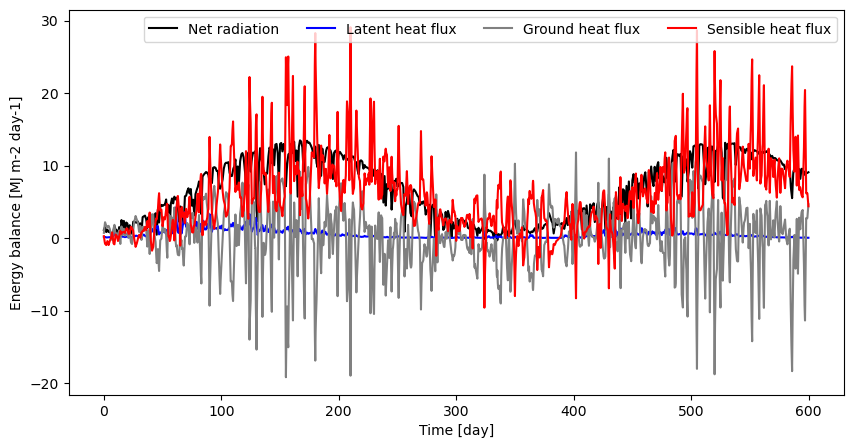

In [26]:
# Plot Energy balance
labels = ['Net radiation', 'Latent heat flux', 'Ground heat flux', 'Sensible heat flux']
colors = ['k', 'b', 'grey', 'red']

fig, ax = plt.subplots(1, 1, figsize=(10,5), sharex=True)
for i in range(4):
    ax.plot(solution_untrained.ts[1], solution_untrained.ys[1][:,i], color=colors[i], label=labels[i])
ax.set(xlabel='Time [day]', ylabel='Energy balance [MJ m-2 day-1]')
ax.legend(ncol=len(labels))


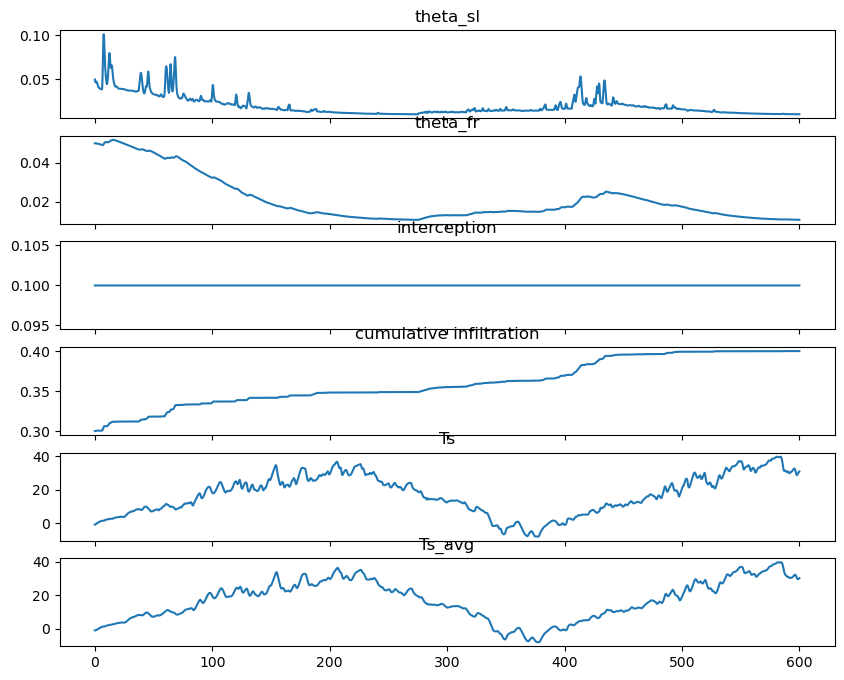

In [27]:
labels = ['theta_sl', 'theta_fr', 'interception', 'cumulative infiltration', 'Ts', 'Ts_avg']
fig, axes = plt.subplots(len(labels), 1, figsize=(10,8), sharex=True)
for i in range(len(labels)):
    ax = axes[i]
    ax.plot(solution_untrained.ts[0][:], solution_untrained.ys[0][:,i])
    ax.set(title=labels[i])


In [28]:
# labels = ['theta_sl', 'theta_fr', 'interception', 'cumulative infiltration', 'Ts', 'Ts_avg']
# fig, axes = plt.subplots(len(labels), 1, figsize=(10,12), sharex=True)
# for i in range(len(labels)):
#     ax = axes[i]
#     ax.plot(solution_untrained.ts[:], solution_untrained.ys[:,i])
#     ax.set(title=labels[i])


## Estimate the model parameters using Adam-based optimization method

In [29]:
t0, t1, dt0 = 0, 400, 0.1
ts_train=jnp.arange(t0,t1,dt0)
saveat_only_rhs_train = diffrax.SaveAt(ts=ts_train)

ytrue_train = ushn2_forcings.interpolate_time_by_varn('SWC', ts_train)
ytrue_train = jnp.expand_dims(ytrue_train, axis=0)
y0          = jnp.expand_dims(y0, axis=0)

In [30]:
# a = jax.vmap(lsm_ode, in_axes=(None, 0, None))(ts_train, jnp.concatenate([y0,y0]), ushn2_forcings)
# b = jax.vmap(lsm_ode, in_axes=(None, 0, None))(ts_train, y0, ushn2_forcings)

In [31]:
# grad_loss(lsm_ode, ts_train, ytrue_train, y0)

In [32]:
lsm_ode(ts_train, y0.flatten(), saveat_only_rhs_train, ushn2_forcings)

Solution(
  t0=f64[],
  t1=f64[],
  ts=f64[4000],
  ys=f64[4000,6],
  interpolation=None,
  stats={
    'max_steps':
    i64[],
    'num_accepted_steps':
    i64[],
    'num_rejected_steps':
    i64[],
    'num_steps':
    i64[]
  },
  result=i64[],
  solver_state=None,
  controller_state=None,
  made_jump=None
)

In [33]:
@eqx.filter_value_and_grad
def grad_loss(model, ti, yi, y0):
    # y_pred = jax.vmap(model, in_axes=(None, 0))(ti, yi[:, 0])
    solution = jax.vmap(model, in_axes=(None, 0, None, None))(ti, y0, saveat_only_rhs_train, ushn2_forcings)
    y_pred   = solution.ys[...,0]
    return jnp.mean((yi - y_pred) ** 2)

@eqx.filter_jit
def make_step(ti, yi, y0, model, opt_state):
    loss, grads = grad_loss(model, ti, yi, y0)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

lr, steps = 1e-3, 200
# lr, steps = 1e-3, 2
optim = optax.adam(lr)
opt_state = optim.init(eqx.filter(lsm_ode, eqx.is_array_like))
# for step, (yi,) in zip(
#     range(steps), dataloader((_ys,), batch_size, key=loader_key)
# ):
for step in range(steps):
    start = time.time()
    # loss, lsm_ode, opt_state = make_step(ts_train, ytrue_train, y0, lsm_ode, opt_state)
    loss, grads = grad_loss(lsm_ode, ts_train, ytrue_train, y0)
    # print(opt_state[0].mu.lsm.infiltration.theta_sat)
    updates, opt_state = optim.update(grads, opt_state)
    # print(opt_state[0].mu.lsm.infiltration.theta_sat, updates.lsm.infiltration.theta_sat)
    lsm_ode = eqx.apply_updates(lsm_ode, updates)
    end = time.time()
    # print(f"Step: {step}, Loss: {loss}, Computation time: {end - start}")
    if (step % 10) == 0 or step == steps - 1:
        print(f"Step: {step}, Loss: {loss}, Computation time: {end - start}")


Step: 0, Loss: 0.0016167106775680283, Computation time: 5.5527167320251465
Step: 10, Loss: 0.0010042520399398895, Computation time: 0.845020055770874
Step: 20, Loss: 0.000723671830519253, Computation time: 0.8467729091644287
Step: 30, Loss: 0.0006174554295575381, Computation time: 0.8475260734558105
Step: 40, Loss: 0.0005875122205334224, Computation time: 0.8429100513458252
Step: 50, Loss: 0.0005535907948114457, Computation time: 0.8635809421539307
Step: 60, Loss: 0.0005100080741956234, Computation time: 0.8378350734710693
Step: 70, Loss: 0.0004682354354391834, Computation time: 0.8458209037780762
Step: 80, Loss: 0.0004341402501401545, Computation time: 0.8477222919464111
Step: 90, Loss: 0.00040542191816154174, Computation time: 0.845893144607544
Step: 100, Loss: 0.00038223542787391764, Computation time: 0.840803861618042
Step: 110, Loss: 0.00036281040108816786, Computation time: 0.8424439430236816
Step: 120, Loss: 0.00034559035845852247, Computation time: 0.8428540229797363
Step: 130,

In [78]:
lsm_ode.lsm.soil.theta_sat

Array([0.50400264, 0.32173753], dtype=float64)

In [ ]:
# @eqx.filter_value_and_grad
# def grad_loss(model, ti, yi, y0):
#     # y_pred = jax.vmap(model, in_axes=(None, 0))(ti, yi[:, 0])
#     solution = jax.vmap(model, in_axes=(None, 0, None))(ti, y0, ushn2_forcings)
#     y_pred   = solution.ys[...,0]
#     return jnp.mean((yi - y_pred) ** 2)

# @eqx.filter_jit
# def make_step(ti, yi, y0, model, opt_state):
#     loss, grads = grad_loss(model, ti, yi, y0)
#     updates, opt_state = optim.update(grads, opt_state)
#     model = eqx.apply_updates(model, updates)
#     return loss, model, opt_state

# lr, steps = 1e-3, 250
# optim = optax.adam(lr)
# opt_state = optim.init(eqx.filter(lsm_ode, eqx.is_array_like))
# # for step, (yi,) in zip(
# #     range(steps), dataloader((_ys,), batch_size, key=loader_key)
# # ):
# for step in range(steps):
#     start = time.time()
#     # loss, lsm_ode, opt_state = make_step(ts, ytrue, y0, lsm_ode, opt_state)
#     loss, grads = grad_loss(lsm_ode, ts_train, ytrue_train, y0)
#     # print(opt_state[0].mu.lsm.infiltration.theta_sat)
#     updates, opt_state = optim.update(grads, opt_state)
#     # print(opt_state[0].mu.lsm.infiltration.theta_sat, updates.lsm.infiltration.theta_sat)
#     lsm_ode = eqx.apply_updates(lsm_ode, updates)
#     end = time.time()
#     if (step % 50) == 0 or step == steps - 1:
#         print(f"Step: {step}, Loss: {loss}, Computation time: {end - start}")


## Run the trained model again

### With auxiliary states

In [13]:
# calculate_lsm_vector_mass_energy(
#     0, y0.flatten(), lsm_ode.lsm.soil, lsm_ode.lsm.surface, ushn2_forcings)

In [25]:
# # Also, we need to save the auxiliary states
# from lsm_jax.models import calculate_lsm_vector_mass_energy
# rhs = lambda t, y, args: calculate_lsm_vector_mass_energy(
#     t, y, lsm_ode.lsm.soil, lsm_ode.lsm.surface, args)[0]
# aux = lambda t, y, args: calculate_lsm_vector_mass_energy(
#     t, y, lsm_ode.lsm.soil, lsm_ode.lsm.surface, args)[1]

# rhs_states = diffrax.SubSaveAt(ts=ts)
# aux_states = diffrax.SubSaveAt(ts=ts, fn=aux)
# saveat = diffrax.SaveAt(subs=[rhs_states, aux_states])

# solution = diffrax.diffeqsolve(
#         diffrax.ODETerm(rhs),
#         diffrax.Kvaerno5(),
#         # diffrax.Euler(),
#         # diffrax.ImplicitEuler(
#         #     diffrax.NewtonNonlinearSolver(rtol=1e-12, atol=1e-12)
#         # ),
#         t0=ts[0],
#         t1=ts[-1],
#         dt0=0.1,
#         y0=y0.flatten(),
#         max_steps=40000,
#         stepsize_controller=diffrax.PIDController(rtol=1e-8, atol=1e-8),
#         # stepsize_controller=diffrax.PIDController(rtol=1e-12, atol=1e-12),
#         saveat=saveat,
#         args=ushn2_forcings
#     )
# ytrue    = ushn2_forcings.interpolate_time_by_varn('SWC', ts)

In [80]:
solution = lsm_ode(ts, y0.flatten(), saveat_both, ushn2_forcings)
ytrue    = ushn2_forcings.interpolate_time_by_varn('SWC', ts)

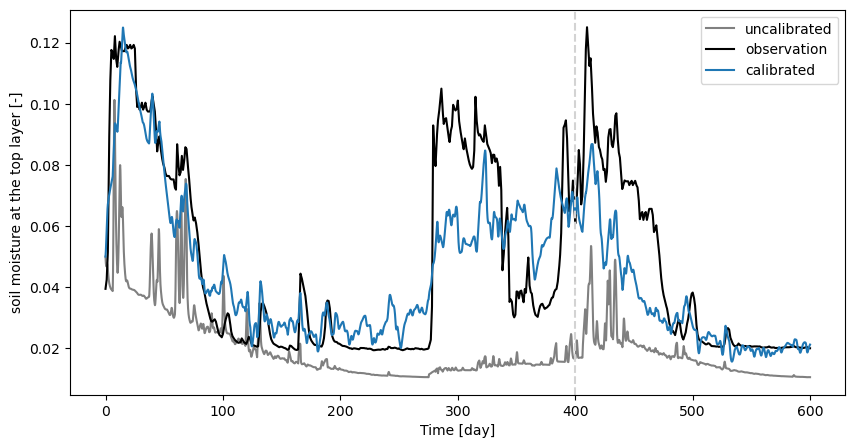

In [81]:
# Plot SWC
fig, ax = plt.subplots(1, 1, figsize=(10,5), sharex=True)
ax.plot(solution_untrained.ts[0], solution_untrained.ys[0][:,0], color='grey', label='uncalibrated')
ax.plot(ts, ytrue.flatten(), color='black', label='observation')
ax.plot(solution.ts[0], solution.ys[0][:,0], color='tab:blue', label='calibrated')
ax.axvline(x=ts_train[-1], color='lightgrey', linestyle='--')
ax.set(xlabel='Time [day]', ylabel='soil moisture at the top layer [-]')
ax.legend()

<AxesSubplot: >

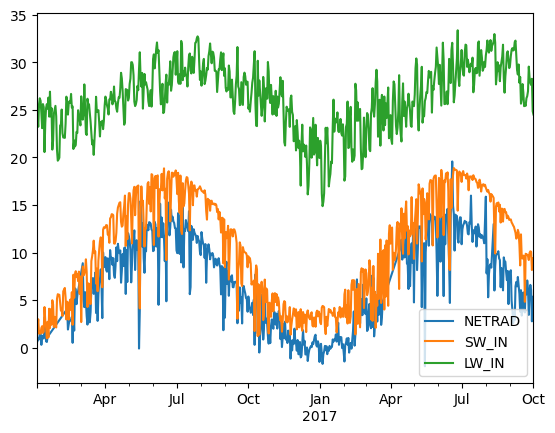

In [12]:
# df_obs[['NETRAD', 'G', 'LE', 'H']].plot()
df_obs[['NETRAD', 'SW_IN', 'LW_IN']].plot()

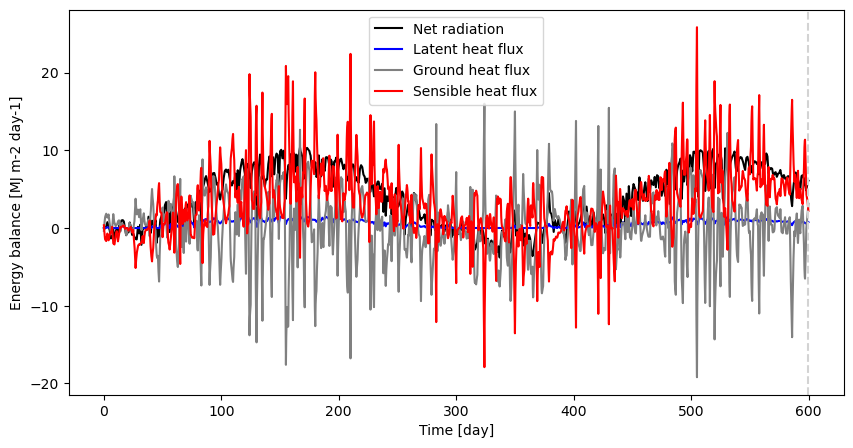

In [44]:
# Plot Energy balance
labels = ['Net radiation', 'Latent heat flux', 'Ground heat flux', 'Sensible heat flux']
colors = ['k', 'b', 'grey', 'red']

fig, ax = plt.subplots(1, 1, figsize=(10,5), sharex=True)
for i in range(4):
    ax.plot(solution.ts[1], solution.ys[1][:,i], color=colors[i], label=labels[i])
ax.axvline(x=ts_train[-1], color='lightgrey', linestyle='--')
ax.set(xlabel='Time [day]', ylabel='Energy balance [MJ m-2 day-1]')
ax.legend()


### No auxiliary states

In [ ]:
solution = lsm_ode(ts, y0.flatten(), ushn2_forcings)
ytrue    = ushn2_forcings.interpolate_time_by_varn('SWC', ts)

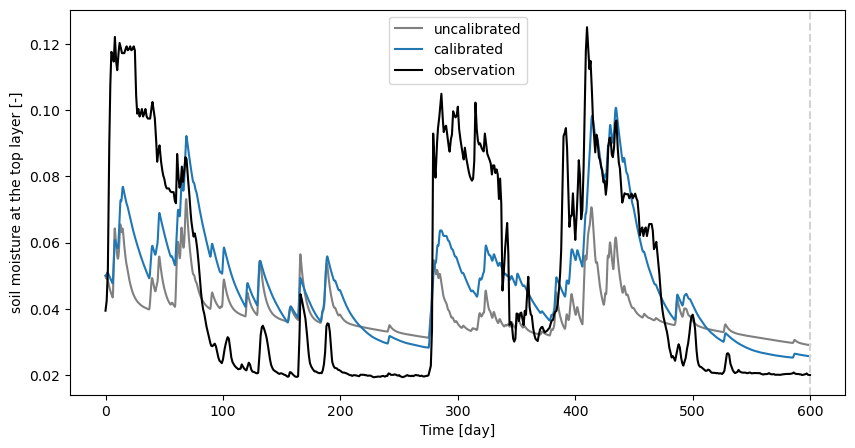

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(10,5), sharex=True)
ax.plot(solution_untrained.ts, solution_untrained.ys[:,0], color='grey', label='uncalibrated')
ax.plot(solution.ts, solution.ys[:,0], color='tab:blue', label='calibrated')
ax.plot(ts, ytrue.flatten(), color='black', label='observation')
ax.axvline(x=ts_train[-1], color='lightgrey', linestyle='--')
ax.set(xlabel='Time [day]', ylabel='soil moisture at the top layer [-]')
ax.legend()

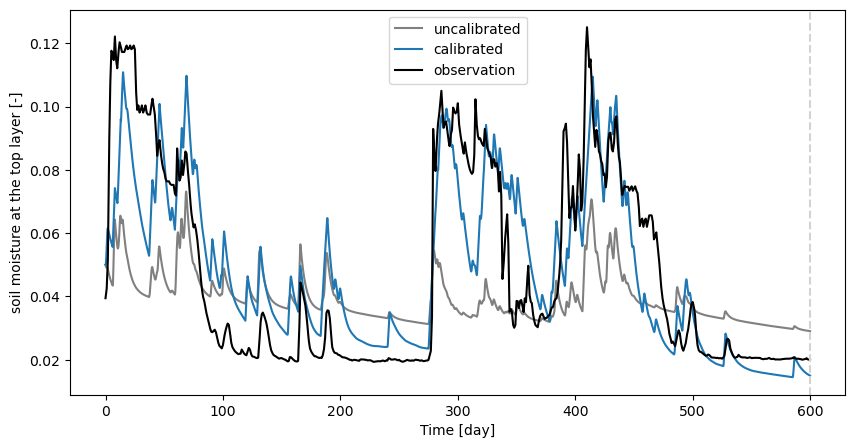

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(10,5), sharex=True)
ax.plot(solution_untrained.ts, solution_untrained.ys[:,0], color='grey', label='uncalibrated')
ax.plot(solution.ts, solution.ys[:,0], color='tab:blue', label='calibrated')
ax.plot(ts, ytrue.flatten(), color='black', label='observation')
ax.axvline(x=ts_train[-1], color='lightgrey', linestyle='--')
ax.set(xlabel='Time [day]', ylabel='soil moisture at the top layer [-]')
ax.legend()

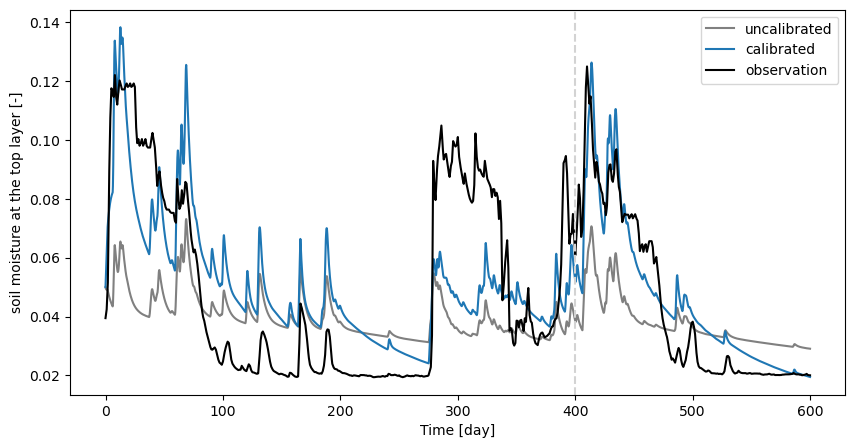

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10,5), sharex=True)
ax.plot(solution_untrained.ts, solution_untrained.ys[:,0], color='grey', label='uncalibrated')
ax.plot(solution.ts, solution.ys[:,0], color='tab:blue', label='calibrated')
ax.plot(ts, ytrue.flatten(), color='black', label='observation')
ax.axvline(x=ts_train[-1], color='lightgrey', linestyle='--')
ax.set(xlabel='Time [day]', ylabel='soil moisture at the top layer [-]')
ax.legend()

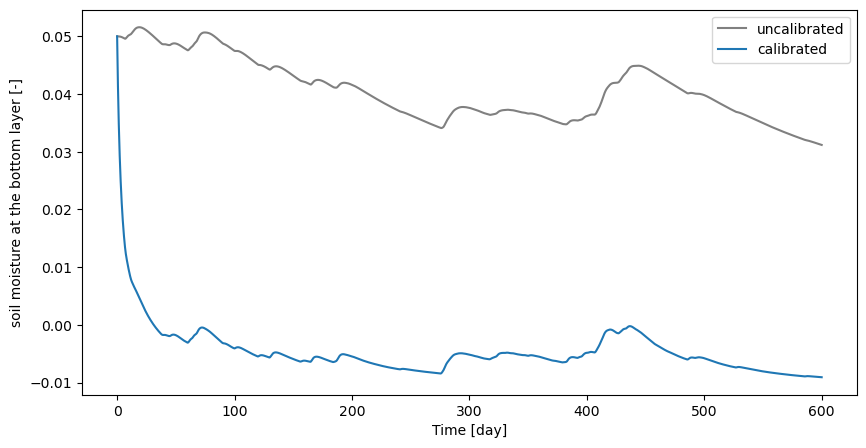

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10,5), sharex=True)
ax.plot(solution_untrained.ts, solution_untrained.ys[:,1], color='grey', label='uncalibrated')
ax.plot(solution.ts, solution.ys[:,1], color='tab:blue', label='calibrated')
ax.set(xlabel='Time [day]', ylabel='soil moisture at the bottom layer [-]')
ax.legend()

In [48]:
# lsm_ode.lsm.fr_water_retention.theta_sat
# lsm_ode.lsm.infiltration.theta_sat

In [49]:
# parameters = dict(
#     dfr=jnp.array(2.), dsl=jnp.array(0.20),
#     alpha_sl=jnp.array(1.32), alpha_fr=jnp.array(1.32),
#     n_sl=jnp.array(2.), n_fr=jnp.array(2.),
#     ksat_sl=jnp.array(3e-7*86400), ksat_fr=jnp.array(3e-7*86400),
#     theta_r_sl=jnp.array(0.0001), theta_r_fr=jnp.array(0.0001),
#     theta_sat_sl=jnp.array(0.43), theta_sat_fr=jnp.array(0.43),
#     theta_wp=jnp.array(0.08), theta_lim=jnp.array(0.2),
#     tamin=jnp.array(-1.), tamax=jnp.array(40.), taopt=jnp.array(22.), w=jnp.array(0.01),
#     rsmin=jnp.array(100.), dh=jnp.array(2.5),
#     zh=jnp.array(5.), zm=jnp.array(5.), zoh=jnp.array(0.5/2.5), zom=jnp.array(0.5),
#     xit=jnp.array(0.8), fbs=jnp.array(.2), fv=jnp.array(0.8)
# )

In [19]:
# labels = ['theta_sl', 'theta_fr', 'interception', 'cumulative infiltration']
# fig, axes = plt.subplots(len(labels)+len(ushn2_forcings.keys()), 1, figsize=(10,12), sharex=True)
# for i in range(len(labels)):
#     ax = axes[i]
#     ax.plot(ts[:], ys[:,i])
#     ax.set(title=labels[i])

# for i,(varn,data) in enumerate(ushn2_forcings.items()):
#     ax = axes[i+len(labels)]
#     ax.plot(data.ts, data.ys)
#     ax.set(title=varn, xlim=[t0, t1])


In [20]:
# lsm_ode

In [21]:
# opt_state

In [22]:
# lsm_ode

# Hybridize it with DL

The ODE:

\begin{align}
\frac{d\theta_{sl}}{dt} &= \frac{1}{d_{sl}}[I-f_{bs}E_{bs}-f_{v}\xi_tE_{v,rh}-D_r-HR] + DL(forcings)  \qquad &(\text{surface soil layer})\\
\frac{d\theta_{fr}}{dt} &= \frac{1}{d_{fr}}[D_r-f_{v}(1-\xi_t)E_{v,fr}+HR-L_e]  \qquad &(\text{fractured rock sublayer}) \\
\end{align}


## Create an DL-based ODE class

In [ ]:
# class LSMODEHybrid(eqx.Module):
#     lsm: LSMVectorHybrid

#     def __init__(self, forcing_list, out_corrected_indices, key, parameters, **kwargs):
#         super().__init__(**kwargs)
#         self.lsm = LSMVectorHybrid(
#             forcing_list, out_corrected_indices, key, **parameters)

#     def __call__(self, ts, y0, forcings):
#         solution = diffrax.diffeqsolve(
#             diffrax.ODETerm(self.lsm),
#             diffrax.Euler(),
#             t0=ts[0],
#             t1=ts[-1],
#             dt0=ts[1] - ts[0],
#             y0=y0,
#             # stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
#             saveat=diffrax.SaveAt(ts=ts),
#             args=forcings
#         )
#         return solution.ys


In [ ]:
# lsm_ode_hybrid = LSMODEHybrid(
#     forcing_list=['P', 'G', 'NETRAD', 'VPD', 'TA', 'WS', 'LAI'], 
#     out_corrected_indices=[1], key=jrandom.PRNGKey(1234), parameters=parameters
# )

In [ ]:
# t0, t1, dt0 = 0, 600, 1
# ts=jnp.arange(t0,t1,dt0)
# y0 = jnp.array([0.05, 0.05, 0.1, 0.3])
# ys_untrained = lsm_ode_hybrid(ts, y0, ushn2_forcings)

## Train the hybrid model

In [ ]:
# t0, t1, dt0 = 0, 400, 1
# ts_train=jnp.arange(t0,t1,dt0)

# ytrue_train = ushn2_forcings.evaluate('SWC', ts_train)
# ytrue_train = jnp.expand_dims(ytrue_train, axis=0)
# y0    = jnp.expand_dims(y0, axis=0)

In [ ]:
# @eqx.filter_value_and_grad
# def grad_loss(model, ti, yi, y0):
#     # y_pred = jax.vmap(model, in_axes=(None, 0))(ti, yi[:, 0])
#     y_pred = jax.vmap(model, in_axes=(None, 0, None))(ti, y0, ushn2_forcings)[...,0]
#     return jnp.mean((yi - y_pred) ** 2)

# @eqx.filter_jit
# def make_step(ti, yi, y0, model, opt_state):
#     loss, grads = grad_loss(model, ti, yi, y0)
#     updates, opt_state = optim.update(grads, opt_state)
#     model = eqx.apply_updates(model, updates)
#     return loss, model, opt_state

# lr, steps = 1e-3, 250
# optim = optax.adam(lr)
# opt_state = optim.init(eqx.filter(lsm_ode_hybrid, eqx.is_array_like))
# # for step, (yi,) in zip(
# #     range(steps), dataloader((_ys,), batch_size, key=loader_key)
# # ):
# for step in range(steps):
#     start = time.time()
#     loss, grads = grad_loss(lsm_ode_hybrid, ts_train, ytrue_train, y0)
#     updates, opt_state = optim.update(grads, opt_state)
#     lsm_ode_hybrid = eqx.apply_updates(lsm_ode_hybrid, updates)
#     end = time.time()
#     if (step % 50) == 0 or step == steps - 1:
#         print(f"Step: {step}, Loss: {loss}, Computation time: {end - start}")


## Run the trained model again

In [ ]:
# ys = lsm_ode_hybrid(ts, y0.flatten(), ushn2_forcings)
# ytrue = ushn2_forcings.evaluate('SWC', ts)

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(10,5), sharex=True)
# ax.plot(ts, ys_untrained[:,0], color='grey', label='uncalibrated')
# ax.plot(ts, ys[:,0], color='tab:blue', label='calibrated')
# ax.plot(ts, ytrue.flatten(), color='black', label='observation')
# ax.axvline(x=ts_train[-1], color='lightgrey', linestyle='--')
# ax.set(xlabel='Time [day]', ylabel='soil moisture at the top layer [-]')
# ax.legend()

# Backup

In [23]:
# eqx.filter(lsm_ode, lambda x: isinstance(x, (float, complex)))
# eqx.filter(lsm_ode, eqx.is_array_like)

In [24]:
# updates

In [25]:
# model.tree_flatten()

In [26]:
# lsm_ode.tree_flatten()

In [27]:
# def init_fn(params):
#     mu = jax.tree_util.tree_map(  # First moment
#         lambda t: jnp.zeros_like(t, dtype=None), params)
#     nu = jax.tree_util.tree_map(jnp.zeros_like, params)  # Second moment
#     return optax.ScaleByAdamState(count=jnp.zeros([], jnp.int32), mu=mu, nu=nu)
# init_model = init_fn(lsm_ode)
# init_model.mu.lsm.infiltration.theta_sat

# def init_fn2(params):
#     mu = jax.tree_util.tree_map(jnp.zeros_like, params)  # First moment
#     s = jax.tree_util.tree_map(jnp.zeros_like, params)  # Second Central moment
#     return optax.ScaleByBeliefState(count=jnp.zeros([], jnp.int32), mu=mu, nu=s)
# init_fn2(lsm_ode)

# optim = optax.adabelief(1e-3)
# opt_state = optim.init(eqx.filter(lsm_ode, eqx.is_array_like))
# opt_state

# def grad_loss2(model, ti, yi, y0):
#     # y_pred = jax.vmap(model, in_axes=(None, 0))(ti, yi[:, 0])
#     y_pred = jax.vmap(model, in_axes=(None, 0, None))(ti, y0, ushn2_forcings)[...,0]
#     return jnp.mean((yi - y_pred) ** 2)
# eqx.filter_grad(grad_loss2)(lsm_ode, ts, ytrue, y0)

In [28]:
# @eqx.filter_value_and_grad
# def grad_loss(model, ti, yi):
#     y_pred = jax.vmap(model, in_axes=(None, 0))(ti, yi[:, 0])
#     return jnp.mean((yi - y_pred) ** 2)

# @eqx.filter_jit
# def make_step(ti, yi, model, opt_state):
#     loss, grads = grad_loss(model, ti, yi)
#     updates, opt_state = optim.update(grads, opt_state)
#     model = eqx.apply_updates(model, updates)
#     return loss, model, opt_state

# optim = optax.adabelief(lr)
# opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))
# opt_state